In [ ]:
import tensorflow as tf       #Библиотека тензорфлоу
import numpy as np            #Библиотека numpy
import random                 #Импортируем модуль для генерации рандомных значений
import pickle                 #Модуль для сохранения результатов в файл
import cv2                    #Модуль для работы с картинками и видео (нужно для предобработки данных и записи результата)
import random

#Импортируем тип данных deque из встроенного модуля питона
from collections import deque   #deque - это список где автоматический удаляются старые значения при добовлении новых, чтобы не было переполнение памяти.
import matplotlib.pyplot as plt #Импортируем модуль pyplot из бибиотеки matplotlib

from tensorflow.keras.models import load_model, Model, Sequential #Импортируем функции для создания и загрузки модели из тензорфлоу
from tensorflow.keras.layers import *                             #Импортируем все слои из кераса
from tensorflow.keras.optimizers import RMSprop                   #Импортируем оптимизатор RMSprop
from tensorflow.keras import backend as K                         #Импортируем модуль для бэкэнда кераса
from tensorflow.keras.utils import to_categorical                 #Импортируем функцию для удобного onehot энкодинга

import pickle                         #Модуль для сохранения результатов в файл
from google.colab import output       #Импортируем модуль который помогает очищать вывод из ячейки колаба.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
class schedule_environment:
  def __init__(self, algorithm, min_curators = 28, max_curators = 32):
    self.algorithm = algorithm


    self.min_curators = min_curators
    self.max_curators = max_curators
    self.num_curators = random.randint(min_curators, max_curators)

    self.num_rows = 7
    self.num_cols = 9

    self.duty_timetable = np.ones((self.num_rows, self.num_cols)) * -2

  def get_random_schedule(self, days_good, times_bad):
    schedule = np.zeros((7, 4))
    previously_accessed_indices = []
    previously_accessed_days = []
    i = 0
    while i < days_good:
      x_index, y_index = np.random.randint(0, schedule.shape[0]), np.random.randint(0, schedule.shape[1])
      if x_index not in previously_accessed_days:
        previously_accessed_days.append(x_index)
        previously_accessed_indices.append((x_index, y_index))
        schedule[x_index, y_index] = 1
        i += 1

    i = 0
    while i < times_bad:
      x_index, y_index = np.random.randint(0, schedule.shape[0]), np.random.randint(0, schedule.shape[1])
      if (x_index, y_index) not in previously_accessed_indices:
        previously_accessed_indices.append((x_index, y_index))
        schedule[x_index, y_index] = -1
        i += 1                                                                                  

    curator_schedule = np.zeros((self.num_rows, self.num_cols))                                         
    indices_map = {0:0, 1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:3}
    for i, j in indices_map.items():
      curator_schedule[:, i] = schedule[:, j]

    return curator_schedule

  def create_curator(self):
    traits_list = []
    preferred_time = preferred_time = random.randint(1, 24)
    traits_list.append(preferred_time)

    work_type = np.random.choice(['пол ставки', 'полная ставка'], p = (0.1, 0.9))
    traits_list.append(0.5 if work_type == 'пол ставки' else 1)
    
    if work_type == 'полная ставка':
      num_good_days = random.randint(3, self.num_rows)
      num_bad_times = random.randint(0, self.num_rows - 2)
    else: 
      num_good_days = random.randint(1, self.num_rows)
      num_bad_times = random.randint(0, self.num_rows)

    curator_timetable = self.get_random_schedule(num_good_days, num_bad_times)
    traits_list.append(curator_timetable)

    return np.array(traits_list)
  
  def get_curator_stats(self):
    self.num_curators = random.randint(self.min_curators, self.max_curators)

    self.timezone_stats = np.ones((1, self.max_curators)).astype(np.float32) * -2
    self.employment_stats = np.ones((1, self.max_curators)).astype(np.float32) * -2
    self.schedule_stats = np.ones((1, self.num_rows, self.num_cols, self.max_curators)).astype(np.float32) * -2
    curator_stats = [self.create_curator() for i in range(self.num_curators)]

    for i in range(self.num_curators):
      self.timezone_stats[:, i] = curator_stats[i][0]
      self.employment_stats[:, i] = curator_stats[i][1] 
      self.schedule_stats[:, :, :, i] = curator_stats[i][2]
    
    self.available_manpower = 0.5 * self.employment_stats[self.employment_stats == 0.5].size + self.employment_stats[self.employment_stats == 1].size

  def get_reward(self, i, j):
    curator_index = int(self.duty_timetable[i, j])
    reward = 0

    alpha_reward = self.get_schedule_reward(self.schedule_stats[0, i, j, curator_index])
    reward += alpha_reward
    self.alpha_reward_batch += alpha_reward

    beta_reward = self.get_timezone_reward(self.timezone_stats[0, curator_index], j)
    reward += beta_reward
    self.beta_reward_batch += beta_reward

    gamma_reward = self.get_times_used_reward(curator_index, i, j)
    reward += gamma_reward
    self.gamma_reward_batch += gamma_reward
    return reward

  def get_schedule_reward(self, element):
    if element == 1:
      reward = 1
    elif element == -1:
      reward = -2
    else: 
      reward = 0.01
    return reward

  def get_timezone_reward(self, element, timeslot):
    if timeslot < 0:
      return 0
    if timeslot == 0: local_time = 0
    elif timeslot in [1, 2]: local_time = 8
    elif timeslot in [3, 4]: local_time = 14
    else: timeslot = 19

    reward = 0.15 + -0.002 * min(element - timeslot, element - (24 - timeslot))**2
    return np.clip(reward, -0.1, 0.1)

  def get_times_used_reward(self, curator_index, i, j):
    curator_type = self.employment_stats[0, curator_index]
    if curator_type < 0:
      return -2

    curator = self.duty_timetable[i, j]
    num_times_allowed = curator_type * (self.duty_timetable.size - 8) / self.available_manpower

    times_on_duty = (self.duty_timetable == curator).sum()
    if (self.duty_timetable[i, :] == curator).sum() > 1:
      reward = -2
    elif times_on_duty > num_times_allowed:
      reward = -0.2 * float((times_on_duty - num_times_allowed))
    else: reward = 0.2
    return reward

  def create_schedule(self, train_mode = True, episodes_in_batch = 10):
    timezones = []
    employments = []
    schedules = []
    episode_actions = []
    all_rewards = []

    self.alpha_reward_batch = 0
    self.beta_reward_batch = 0
    self.gamma_reward_batch = 0
    
    for episode in range(episodes_in_batch):
      episode_rewards = []
      self.duty_timetable = np.ones((self.num_rows, self.num_cols)) * -2
      self.get_curator_stats()
      for i in range(self.num_rows):
        for j in range(self.num_cols):
          if not (i >= 7 and j >= 3): #Убераем дни, когда нету интенсивов
            graph = np.append(self.duty_timetable.reshape(1, self.num_rows, self.num_cols, 1), self.schedule_stats, axis = 3)

            state = (self.timezone_stats, self.employment_stats, graph)
            if train_mode:
              action = self.algorithm.get_train_action(state)
            else:
              action = self.algorithm.get_test_action(state)

            self.duty_timetable[i, j] = action
            reward = self.get_reward(i, j)
            
            timezones.append(self.timezone_stats[0])
            employments.append(self.employment_stats[0])
            schedules.append(graph[0])
            episode_actions.append([action])
            episode_rewards.append(reward)

      all_rewards += episode_rewards

    total_reward = np.array(all_rewards).sum()
    all_rewards = self.algorithm.preprocess_rewards(all_rewards)

    return timezones, employments, schedules, episode_actions, all_rewards, total_reward

In [ ]:
class REINFORCE:
  def __init__(self, gamma = 0.9, load_pretrained = False):
    self.environment = schedule_environment(self)
    self.gamma = gamma
    self.learning_rate = 1e-4
    self.model = self.create_model()
    self.rewards = []
    self.alpha_rewards = []
    self.beta_rewards = []
    self.gamma_rewards = []

    self.save_directory = '/content/drive/My Drive/pretrained_networks/reinforce_schedule/'

    if load_pretrained:
      self.load_results()

  def preprocess_rewards(self, rewards):
    processed_rewards = np.zeros_like(rewards).astype(np.float32) 
    running_add = 0
    for i in reversed(range(0, len(rewards))):
      running_add = running_add * self.gamma + rewards[i] # sum * y (gamma) + reward
      processed_rewards[i] = running_add
    return processed_rewards.reshape(-1, 1)

  def get_train_action(self, state):
    hours, work_type, timetable = state
    probabilities = self.model.predict(state)
    result = np.random.choice(np.arange(self.environment.max_curators), p = probabilities.flatten())
    return result

  def get_test_action(self, state):
    probabilities = model.predict(state)
    return np.argmax(probabilities)

  def create_model(self):
    preferred_time_branch = Input((self.environment.max_curators,))
    worktype_branch = Input((self.environment.max_curators,))
    timetable_branch = Input((self.environment.num_rows, self.environment.num_cols, self.environment.max_curators + 1))

    x1 = Dense(256, activation = 'elu')(preferred_time_branch)
    x1 = Dense(128, activation = 'elu')(x1)

    x2 = Dense(256, activation = 'elu')(worktype_branch)
    x2 = Dense(128, activation = 'elu')(x2)

    x3 = Conv2D(16, (1, 3), strides = (1, 3), activation = 'elu')(timetable_branch)
    x3 = Conv2D(32, (1, 3), strides = (1, 3), activation = 'elu')(x3)
    x3 = Flatten()(x3)
    x3 = Dense(256, activation = 'elu')(x3)
    x3 = Dense(128, activation = 'elu')(x3)

    x = concatenate([x1, x2, x3])
    x = Dense(256, activation = 'elu')(x)
    out = Dense(self.environment.max_curators, activation = 'softmax')(x)
    model = Model([preferred_time_branch, worktype_branch, timetable_branch], out)
    model.compile(optimizer = RMSprop(learning_rate = self.learning_rate), loss = 'sparse_categorical_crossentropy')
    return model

  def save_results(self):
    self.model.save(self.save_directory + 'neural_networkv2.h5')
    with open(self.save_directory + 'rewards_arrayv2', 'wb') as f:
      pickle.dump([self.rewards, self.alpha_rewards, self.beta_rewards, self.gamma_rewards], f)

  def load_results(self):
    self.model = load_model(self.save_directory + 'neural_networkv2.h5')
    with open(self.save_directory + 'rewards_arrayv2', 'rb') as f:
      self.rewards, self.alpha_rewards, self.beta_rewards, self.gamma_rewards = pickle.load(f)

  def train_algorithm(self, episodes_in_batch = 10, train_times = 1000):
    for i in range(train_times):
      timezones, employments, schedules, episode_actions, all_rewards, total_reward = self.environment.create_schedule(episodes_in_batch = episodes_in_batch)
      self.rewards.append(total_reward)
      self.alpha_rewards.append(self.environment.alpha_reward_batch)
      self.beta_rewards.append(self.environment.beta_reward_batch)
      self.gamma_rewards.append(self.environment.gamma_reward_batch)
      
      timezones = np.array(timezones).astype(np.float32)
      employments = np.array(employments).astype(np.float32)
      schedules = np.array(schedules).astype(np.float32)
      episode_actions = np.array(episode_actions).astype(np.float32)
      all_rewards = np.array(all_rewards)

      self.model.train_on_batch([timezones, employments, schedules], episode_actions, sample_weight = all_rewards)

      if i % 10 == 0:
        show_rewards(self.rewards, self.alpha_rewards, self.beta_rewards, self.gamma_rewards)
        self.save_results()

In [ ]:
def moving_average(data, width = 50): #data - входной массив, width - длина на которое считаем скользящее среднее.
  width = min(width, len(data))       #Длина свёртки (минимум из заданной длины свёртки и длины датасета)
  data = np.concatenate([np.repeat(data[0], width), data])    #Вместо паддинга из нулей, мы создадим паддинг для свёртки из первого значения массива. Весь паддинг будет слева (в начале массива)
  return np.convolve(data, np.ones(width), 'valid') / width   #Возвращаем результат свёртки данных на фильтр из единиц - наше скользящее среднее

def show_rewards(episode_rewards, alpha_rewards, beta_rewards, gamma_rewards):
  output.clear()
  fig, axes = plt.subplots(2, 2, figsize = (20, 10))
  axes[0,0].plot(episode_rewards, color = 'blue', linestyle = '--', label = 'Награда за итерацию (после обработки)')
  axes[0,0].plot(moving_average(episode_rewards), color = 'red', label = 'Скользящее среднее награды (после обработки)')
  axes[0,0].axhline(y = 0, color='k', linestyle='-')
  axes[0,0].legend()

  axes[0,1].plot(alpha_rewards, color = 'green', linestyle = '--', label = 'Награда за итерацию (график по желанию)')
  axes[0,1].plot(moving_average(alpha_rewards), color = 'orange', label = 'Скользящее среднее награды (график по желанию)')
  axes[0,1].axhline(y = 0, color='k', linestyle='-')
  axes[0,1].legend()

  axes[1,0].plot(beta_rewards, color = 'blueviolet', linestyle = '--', label = 'Награда за итерацию (временной пояс)')
  axes[1,0].plot(moving_average(beta_rewards), color = 'gold', label = 'Скользящее среднее награды (временной пояс)')
  axes[1,0].axhline(y = 0, color='k', linestyle='-')
  axes[1,0].legend()

  axes[1,1].plot(gamma_rewards, color = 'yellow', linestyle = '--', label = 'Награда за итерацию (количество дежурств)')
  axes[1,1].plot(moving_average(gamma_rewards), color = 'purple', label = 'Скользящее среднее награды (количество дежурств)')
  axes[1,1].axhline(y = 0, color='k', linestyle='-')
  axes[1,1].legend()

  plt.show()

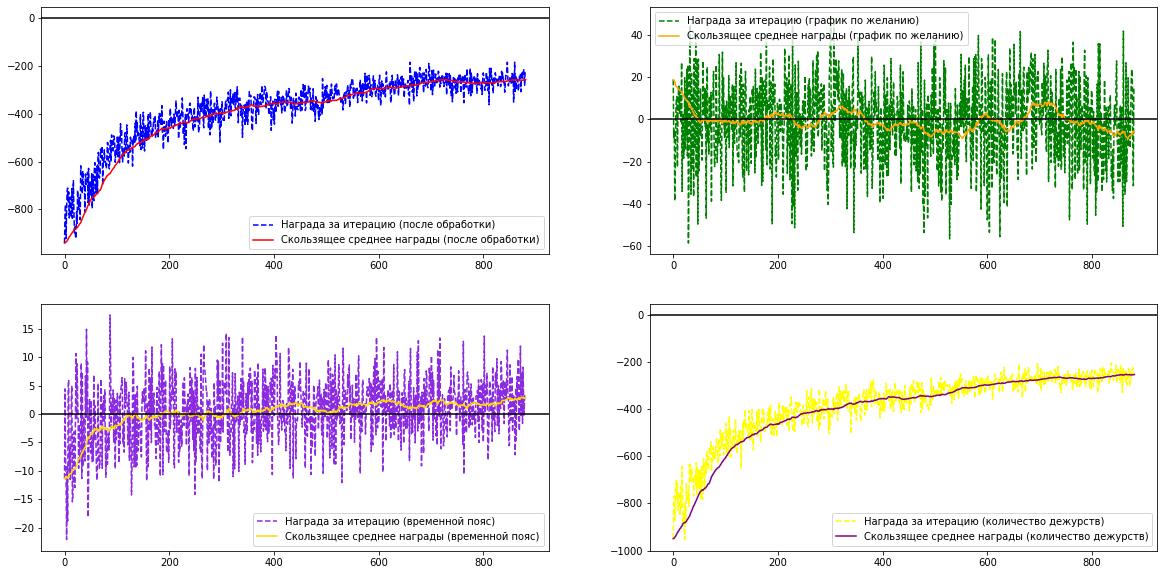

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
algorithm = REINFORCE(load_pretrained = False)
algorithm.train_algorithm(train_times = 10000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


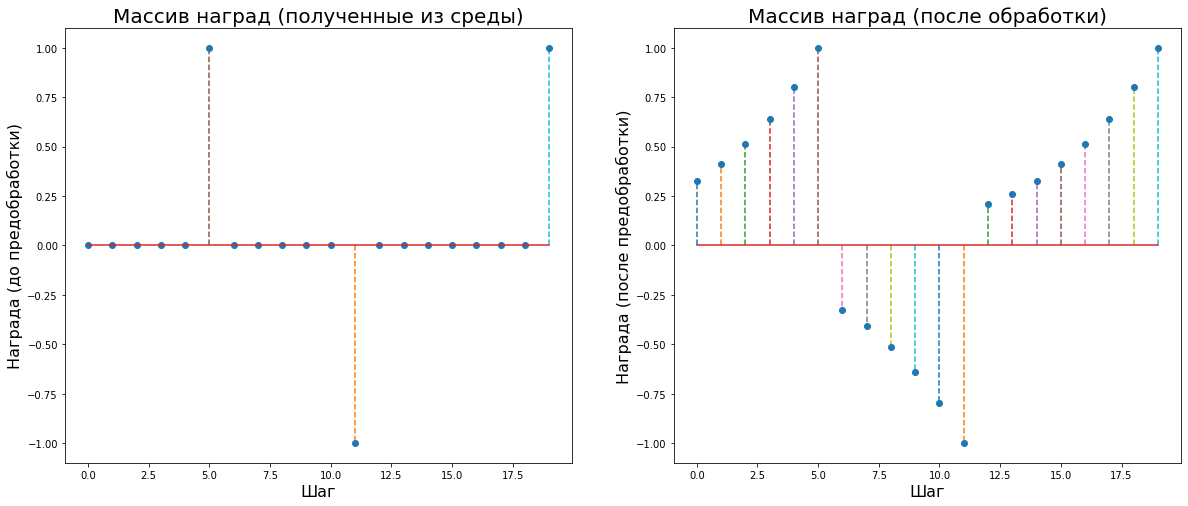

In [ ]:
def preprocess_rewards_continuous(rewards):
  gamma = 0.8
  processed_rewards = np.zeros_like(rewards).astype(np.float32) 
  running_add = 0
  for i in reversed(range(0, len(rewards))):
    running_add = running_add * gamma + rewards[i] # sum * y (gamma) + reward
    print(running_add)
    processed_rewards[i] = running_add
  return processed_rewards.reshape(-1, 1)

def preprocess_rewards_sparse(rewards):
  discounted_rewards = np.zeros_like(rewards).astype(np.float32) 
  running_add = 0
  gamma = 0.8
  for i in reversed(range(len(discounted_rewards))): #Iterate through the list of rewards in reverse
      if rewards[i] != 0: running_add = 0 # reset the sum, since this was a game boundary
      running_add = rewards[i] + running_add * gamma # bellman equation
      discounted_rewards[i] = running_add
  return discounted_rewards

rewards_array = [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 1]

fig, axes = plt.subplots(1, 2, figsize = (20, 8))

axes[0].stem(rewards_array, linefmt = '--')
axes[0].set_title('Массив наград (полученные из среды)', fontsize = 20)
axes[0].set_xlabel('Шаг', fontsize = 16)
axes[0].set_ylabel('Награда (до предобработки)', fontsize = 16)

axes[1].stem(preprocess_rewards_sparse(rewards_array), linefmt = '--')
axes[1].set_title('Массив наград (после обработки)', fontsize = 20)
axes[1].set_xlabel('Шаг', fontsize = 16)
axes[1].set_ylabel('Награда (после предобработки)', fontsize = 16)

plt.show()